In [1]:
import numpy as np
import networkx as nx
import netgraph
import matplotlib.pylab as plt
import os
from tqdm import tqdm

os.makedirs("./Clique-chains", exist_ok=True)

from Qommunity.samplers.hierarchical.advantage_sampler import AdvantageSampler
from Qommunity.searchers.hierarchical_community_searcher import HierarchicalCommunitySearcher

In [2]:
def plot_network_in_communities(graph, comms, filename=None, community_to_color=None, hub_size=False, node_labels=False, ax=None):
  # Determine node size based on eigenvector centrality
  if hub_size==False:
    eigen_centrality = 5
  else:
    eigen_centrality = {node: hub_size*eigen for node, eigen in nx.eigenvector_centrality(graph).items()}
  directed = nx.is_directed(graph)

  # Organize nodes and colors
  node_to_community = dict()
  for community_id, c in enumerate(comms):
      for node in c:
          node_to_community[node] = community_id
  if community_to_color==None:
    community_to_color = np.random.rand(community_id+1,3)
  node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}
  
  # Plotting
  netgraph.Graph(graph,
        node_color=node_color, edge_alpha=1,
        node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
        edge_color="black", node_edge_width=0.1, node_size=eigen_centrality,
        edge_width=.75 if directed else 0.25, node_labels=node_labels, node_label_fontdict={"size": 10}, 
        arrows=True if directed else False, ax=ax
  )
  if filename is not None:
    plt.savefig(filename, bbox_inches='tight')
    print("\nYour plot is saved to {}".format(filename))

# Generating the chain of 3-cliques

In [3]:
def generate_clique(directed=False):
  if directed:
    G = nx.DiGraph()
  else:
    G = nx.Graph()
  G.add_edges_from([(0,1),(1,2),(0,2)])
  c = [0,1,2]
  A_ij = nx.to_numpy_array(G, nodelist=c)
  return A_ij, np.array(c)

def join_cliques(cliques, directed=False):
  A = np.zeros((3*len(cliques),3*len(cliques)))
  for i, cl in enumerate(cliques):
    A[3*i:3*(i+1),3*i:3*(i+1)] = cl
  for i in range(len(cliques)-1):
      A[3*i,3*(i+1)] = 1
      if not directed:
        A[3*(i+1),3*i] = 1
  A[0,-3] = 1
  if not directed:
    A[-3,0] = 1
  return A

def generate_clique_chain(N, directed=False):
    cls = []
    clique_comms = []
    for i in range(N):
        cl, c = generate_clique(directed=directed)
        cls.append(cl)
        clique_comms.append(set(c+3*i))
    A = join_cliques(cls, directed=directed)
    G = nx.from_numpy_array(A, create_using=nx.DiGraph) if directed else  nx.from_numpy_array(A, create_using=nx.Graph)
    return A, G, clique_comms

In [7]:
# Generating the chains
N_cliques = 8
A, G, clique_comms = generate_clique_chain(N_cliques, directed=False)
A_d, G_d, clique_comms_d = generate_clique_chain(N_cliques, directed=True)

In [5]:
## Finding the communities with a classical algorithm

# Undirected
louv_comms = nx.community.louvain_communities(G)
louv_mod = nx.community.modularity(G, louv_comms)
# Directed
louv_comms_d = nx.community.louvain_communities(G_d)
louv_mod_d = nx.community.modularity(G_d, louv_comms_d)

In [13]:
## Finding the communities with the Quantum algorithm in an undirected clique

# Undirected
adv_sampler = AdvantageSampler(G, num_reads=100, use_clique_embedding=True)
searcher = HierarchicalCommunitySearcher(adv_sampler)
adv_comms, adv_mod = searcher.hierarchical_community_search(return_modularities=True)

In [8]:
## Finding the communities with the Quantum algorithm in a directed clique

# Directed
adv_sampler = AdvantageSampler(G_d, num_reads=100, use_clique_embedding=True)
searcher = HierarchicalCommunitySearcher(adv_sampler)
adv_comms_d, adv_mod_d = adv_comms, adv_mod = searcher.hierarchical_community_search(return_modularities=True)

In [14]:
print("Undirected chain:")
print(f"- Modularity Louvain {louv_mod} with {len(louv_comms)} communities detected")
print(f"- Modularity Annealing {adv_mod} with {len(adv_comms)} communities detected")

print("Directed chain:")
print(f"- Modularity Louvain {louv_mod_d} with {len(louv_comms_d)} communities detected")
print(f"- Modularity Annealing {adv_mod_d} with {len(adv_comms_d)} communities detected")

Undirected chain:
- Modularity Louvain 0.625 with 8 communities detected
- Modularity Annealing 0.625 with 6 communities detected
Directed chain:
- Modularity Louvain 0.626953125 with 8 communities detected
- Modularity Annealing 0.626953125 with 4 communities detected


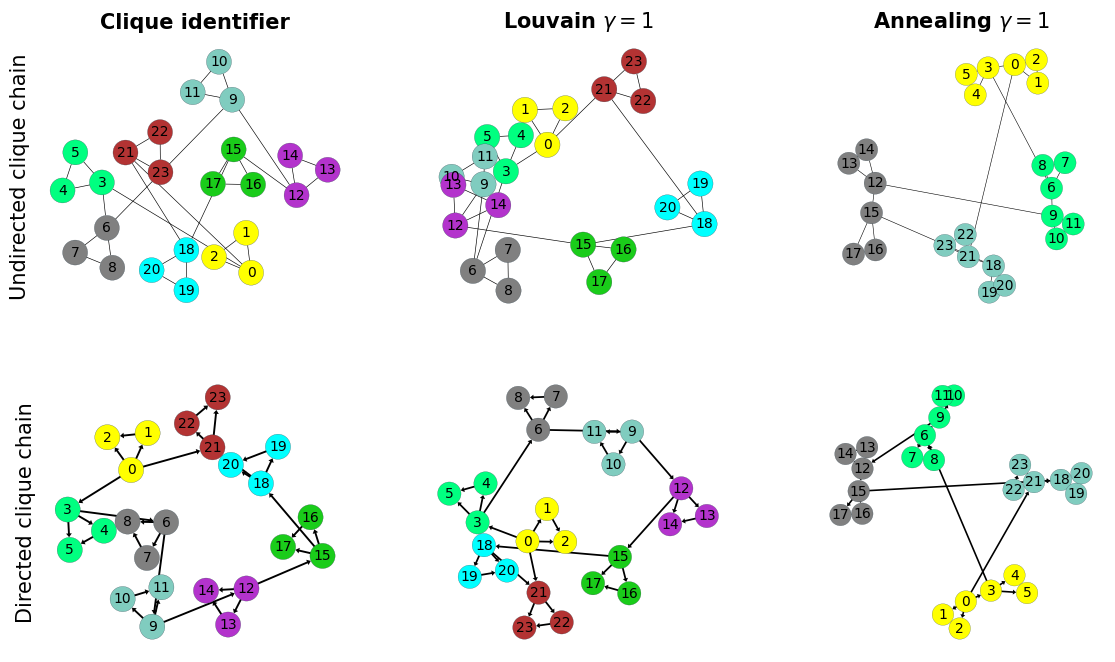

In [12]:
# Plotting the results
# comm_colors = [np.random.rand(3) for i in range(N_cliques)] # For random colors
comm_colors = [
    [1,1,0],
    [0,1,0.5],
    [0.5,.5,0.5],
    [0.5,.8,0.75],
    [0.7,.2,0.8],
    [0.1,0.8,0.1],
    [0,1,1],
    [.7,.2,.2],
]
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(14,8))

plot_network_in_communities(G, clique_comms, community_to_color=comm_colors, node_labels=True, ax=ax1)
plot_network_in_communities(G_d, clique_comms_d, community_to_color=comm_colors, node_labels=True, ax=ax4)
ax1.set_ylabel("Undirected clique chain", fontsize=15)
ax4.set_ylabel("Directed clique chain", fontsize=15)
ax1.set_title("Clique identifier", fontweight="bold", fontsize=15)

# Louvain detection
plot_network_in_communities(G, louv_comms, community_to_color=comm_colors, node_labels=True, ax=ax2)
plot_network_in_communities(G_d, louv_comms_d, community_to_color=comm_colors, node_labels=True, ax=ax5)
ax2.set_title("Louvain " + r'$\gamma=1$', fontweight="bold", fontsize=15)

# DWAVE detection
plot_network_in_communities(G, adv_comms, community_to_color=comm_colors[:len(adv_comms)], node_labels=True, ax=ax3)
plot_network_in_communities(G_d, adv_comms_d, community_to_color=comm_colors[:len(adv_comms_d)], node_labels=True, ax=ax6)
ax3.set_title("Annealing " + r'$\gamma=1$', fontweight="bold", fontsize=15)

plt.savefig(f"./Clique-chains/clique-chain_communities.svg", format='svg', dpi=400)

In [5]:
runs = 5
cs = np.empty(shape=(runs,), dtype=object)
try:
    mods = np.load(f"./Clique-chains/mods_runs-{runs}.npy", allow_pickle=True)
    for run in tqdm(range(runs)):
        cs[run] = np.load(f"./Clique-chains/communities_runs-{runs}.npy", allow_pickle=True)[()]
    exps = list(cs[0]["Lou"].keys())
except:
    exps = [2, 10, 20, 30, 40, 50]
    mods = np.zeros((runs,len(exps),2))
    for run in tqdm(range(runs)):
        cs[run] = {"Lou":{}, "Adv":{}}
        for i, N_cliques in enumerate(exps):
            A, G, clique_comms = generate_clique_chain(N_cliques, directed=False)
            louv_comms = nx.community.louvain_communities(G)
            louv_mod = nx.community.modularity(G, louv_comms)
            
            adv_sampler = AdvantageSampler(G, num_reads=100, use_clique_embedding=True)
            searcher = HierarchicalCommunitySearcher(adv_sampler)
            adv_comms, adv_mod = searcher.hierarchical_community_search(return_modularities=True)

            mods[run,i,:] = [louv_mod, adv_mod]
            cs[run]["Lou"][N_cliques] = louv_comms
            cs[run]["Adv"][N_cliques] = adv_comms

    np.save(f"./Clique-chains/communities_runs-{runs}.npy", cs, allow_pickle=True)
    np.save(f"./Clique-chains/mods_runs-{runs}.npy",mods, allow_pickle=True)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [14:21<00:00, 172.26s/it]


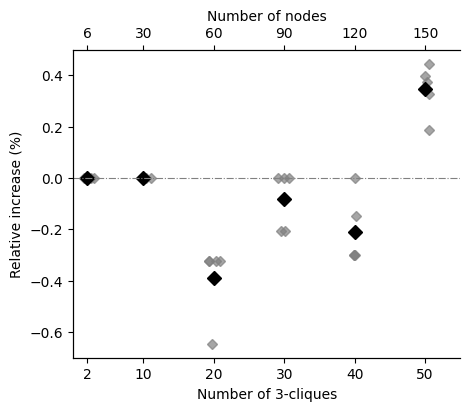

In [22]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
rel_inc = 100 * (mods[:,:,1] - mods[:,:,0]) / mods[:,:,0]
for run in range(runs):
    ax.plot(exps+0.5*np.random.randn(len(exps)), rel_inc[run], "D", color='gray', alpha=0.7, markersize=5)
ax.plot(exps, rel_inc.mean(axis=0), "D", color='black', markersize=7)
ax.hlines(0, 0, exps[-1]+5, linewidth=.8, color='gray', linestyles="-.")

ax_bis = ax.twiny()
ax.spines[["right"]].set_visible(False)
ax_bis.spines[["right"]].set_visible(False)

ax.set_xticks(exps), ax.set_xticklabels(exps)
ax.set_xlim([0, exps[-1]+5])

ax.set_ylabel("Relative increase (%)")
ax.set_xlabel("Number of 3-cliques")
ax_bis.set_xlabel("Number of nodes")
ax_bis.set_xticks(exps)
ax_bis.set_xticklabels(3*np.array(exps))
ax_bis.set_xlim([0, exps[-1]+5])

plt.savefig(f"./Clique-chains/relative-increase_runs-{runs}.svg", format='svg', dpi=400)

In [106]:
consensus_exp_Lou = np.empty(shape=(len(exps),), dtype=object)
consensus_exp_Adv = np.empty(shape=(len(exps),), dtype=object)
N_comms = np.zeros((len(exps),runs,2))
for i, N_cliques in enumerate(exps):
    nodes = 3 * N_cliques
    consensus_Lou = np.zeros((nodes,nodes))
    consensus_Adv = np.zeros((nodes,nodes))
    for run in range(runs):
        # Louvain
        N_comms[i,run,0] = len(cs[run]["Lou"][N_cliques])
        for c in cs[run]["Lou"][N_cliques]:
            for node_i in range(nodes):
                for node_j in range(node_i+1,nodes):
                    together = 1 if ((node_i in c) and (node_j in c)) else 0
                    consensus_Lou[node_i,node_j] += together
                    consensus_Lou[node_j,node_i] += together
        # Advantage
        N_comms[i,run,1] = len(cs[run]["Adv"][N_cliques])
        for c in cs[run]["Adv"][N_cliques]:
            for node_i in range(nodes):
                for node_j in range(node_i+1,nodes):
                    together = 1 if ((node_i in c) and (node_j in c)) else 0
                    consensus_Adv[node_i,node_j] += together
                    consensus_Adv[node_j,node_i] += together
    np.fill_diagonal(consensus_Lou, 0)
    np.fill_diagonal(consensus_Adv, 0)
    consensus_exp_Lou[i] = 100*consensus_Lou/runs
    consensus_exp_Adv[i] = 100*consensus_Adv/runs

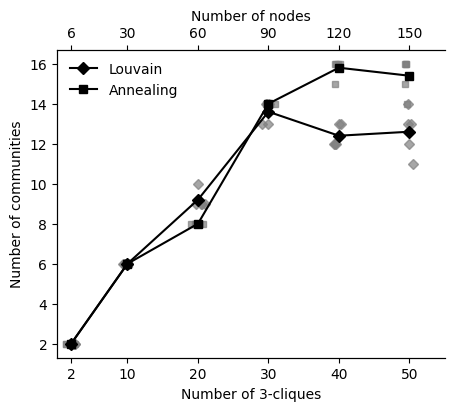

In [125]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
for run in range(runs):
    ax.plot(exps+0.5*np.random.randn(len(exps)), N_comms[:,run,0], "D", color='gray', alpha=0.7, markersize=5)
    ax.plot(exps+0.5*np.random.randn(len(exps)), N_comms[:,run,1], "s", color='gray', alpha=0.7, markersize=5)
ax.plot(exps, N_comms[:,:,0].mean(axis=1), "D-", color='black', label="Louvain")
ax.plot(exps, N_comms[:,:,1].mean(axis=1), "s-", color='black', label="Annealing")
ax.legend(frameon=False)

ax_bis = ax.twiny()
ax.spines[["right"]].set_visible(False)
ax_bis.spines[["right"]].set_visible(False)

ax.set_xticks(exps), ax.set_xticklabels(exps)
ax.set_xlim([0, exps[-1]+5])

ax.set_ylabel("Number of communities")
ax.set_xlabel("Number of 3-cliques")
ax_bis.set_xlabel("Number of nodes")
ax_bis.set_xticks(exps)
ax_bis.set_xticklabels(3*np.array(exps))
ax_bis.set_xlim([0, exps[-1]+5])

plt.savefig(f"./Clique-chains/number-communities_runs-{runs}.svg", format='svg', dpi=400)

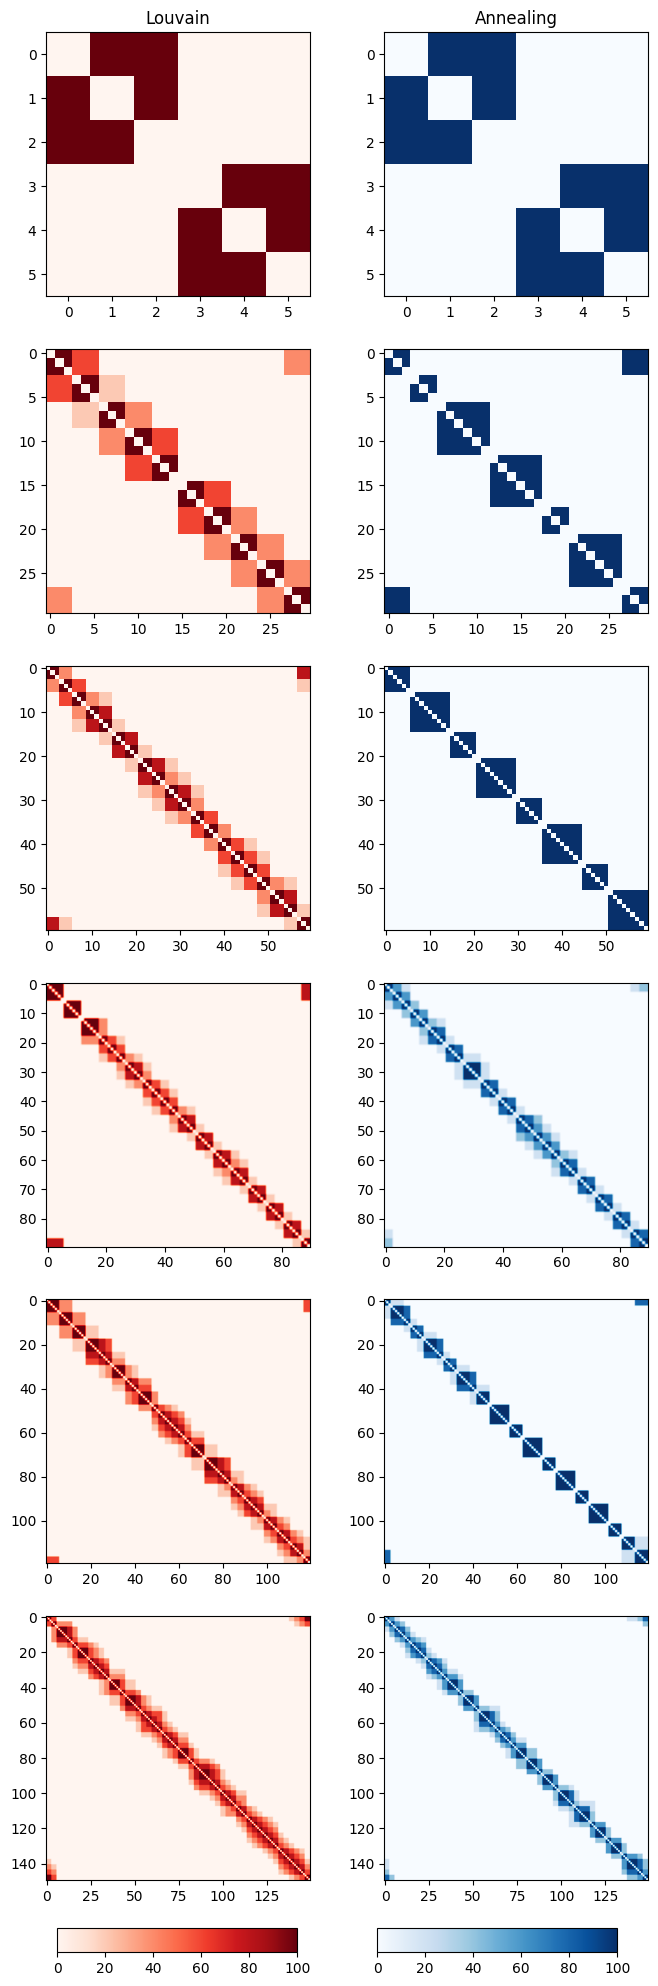

In [123]:
fig, ax = plt.subplots(len(exps),2,figsize=(8,24))
for i, N_cliques in enumerate(exps):
    l = ax[i,0].imshow(consensus_exp_Lou[i], cmap='Reds')
    a = ax[i,1].imshow(consensus_exp_Adv[i], cmap='Blues')
    if i==0:
        ax[0,0].set_title("Louvain")
        ax[0,1].set_title("Annealing")

cax = fig.add_axes([0.15, 0.08, 0.3, 0.01])
fig.colorbar(l, cax=cax, orientation='horizontal')
cax = fig.add_axes([0.55, 0.08, 0.3, 0.01])
fig.colorbar(a, cax=cax, orientation='horizontal')

plt.savefig(f"./Clique-chains/consensus_runs-{runs}.svg", format='svg', dpi=400)